<a href="https://colab.research.google.com/github/Padawanh/NDVI_Predict_PUC_MINAS_TCC/blob/main/TCC_NDVI_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introdução

  O índice de vegetação de diferença normalizada (NDVI) é um indicador simples que pode avaliar se uma região tem vegetação verde viva através de sensores remotos de observação da terra em satélites.

  As plantas absorvem e refletem parte das ondas eletromagnéticas da luz solar e através de sensores na órbita terrestre que captam o que foi refletido temos dados para fomentar a avaliação do comportamento da vegetação de uma região com o NDVI. Isso é possível porque as plantas tendem a absorver boa parte da região espectral correspondente a região visível do vermelho através do seu componente fotossintetizante, a clorofila, e tendem a refletir fortemente a região espectral correspondente ao infravermelho próximo, o NDVI é calculado através de  imagens que correspondem a essas duas faixas espectrais. Por consequência quanto mais folhas uma planta tem, mais esses comprimentos de onda de luz estão sendo afetados em sua resposta espectral que por seguinte é captada pelas imagens de satélite e podem ser avaliadas através do NDVI. 

  Há vários sensores remotos capazes de captar as zonas do vermelho e infravermelho próximo, dentre eles o MODIS (ou espectrorradiômetro de imagem de resolução moderada) embarcado nos satélites Terra (originalmente conhecido como EOS AM-1) e Aqua (originalmente conhecido como EOS PM-1). Esses satélites estão visualizando toda a superfície da Terra a cada 2 dias no máximo. 
  
  O NDVI tende representar os padrões naturais das regiões, detre elas temos as regiões de florestas plantadas que por sua característica perene e por serem um investimento a longo prazo acabam comportando um peso significativo ao seu monitoramento. Ao monitorar e compreender os padrões naturais dessas regiões é possível construir iniciativas preventivas e reativas que garantam o retorno esperado dos plantios florestais.

[Baixar dados do projeto](https://drive.google.com/drive/folders/1Ho2UmkDeDMOQzKD9sAHal4eZPZLy1tbh?usp=sharing)



# Instalação e carregamento

In [ ]:
!pip install geopandas
!pip install -U pip
!pip install rtree
!pip install pygeos
!pip install rasterio
!pip install ipygee
!pip install tslearn
!pip install earthengine-api
!pip install pmdarima
!pip install fbprophet 
!pip install geemap
!pip install sktime


In [ ]:
#Para geo ETL
import ee
import rtree
import pygeos
import geopandas as gp
import fiona
import rasterio
from rasterio.features import shapes
import rasterio.mask
import matplotlib.pyplot as plt
import ee
import geemap
from ipygee import*

# Para modelagem
from IPython.display import Image
import pandas as pd
from pandas import Series
import numpy as np

from pylab import rcParams
import matplotlib
import seaborn as sns

import statsmodels.api as sm

#Para exploração de dados
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

#Para ARIMA
from statsmodels.tsa.arima_model import ARIMA



#Imports para Auto ARIMA
import pmdarima as pm
from pmdarima import model_selection
from pmdarima.utils import tsdisplay

#Imports para Prophet
from fbprophet import Prophet


#Imports para LSTM
from keras.layers import Dense 
from keras.optimizers import SGD
from keras.models import Model
from keras.models import load_model
from keras.models import Sequential
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler

#Para métricas
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error

Conectando com o Google Earth Engine através da API python

In [ ]:
ee.Authenticate()
ee.Initialize()

Conectando com google drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Definindo que os gráficos tem que ser plotados no próprio Jupyter Notebook

In [5]:
%matplotlib inline

# Coleta e transformação de dados

##Geoprocessamento

### Delimitando imagens do MapBiomas


Verificando os metadados das imagens MapBiomas

In [6]:
MapBiomas2019MS = '/content/drive/MyDrive/Databases/ImagensSatelite/mapbiomas-brazil-collection-50-matogrossodosul-2019.tif'
dataset = rasterio.open(MapBiomas2019MS) #Carregando imagem
#Metadados da imagem. Verificando se há um CRS (Sistemas de Referência de Coordenadas), como está atribuido os valores nulos e o tipo de codificação dos pixels.
dataset.meta

{'count': 1,
 'crs': CRS.from_epsg(4326),
 'driver': 'GTiff',
 'dtype': 'uint8',
 'height': 25613,
 'nodata': None,
 'transform': Affine(0.0002694945852358564, 0.0, -58.16851976106298,
       0.0, -0.0002694945852358564, -17.16626609035358),
 'width': 26886}

In [7]:
MapBiomas2009MS = '/content/drive/MyDrive/Databases/ImagensSatelite/mapbiomas-brazil-collection-50-matogrossodosul-2009.tif'
dataset = rasterio.open(MapBiomas2009MS) #Carregando imagem
#Metadados da imagem. Verificando se há um CRS (Sistemas de Referência de Coordenadas), como está atribuido os valores nulos e o tipo de codificação dos pixels.
dataset.meta

{'count': 1,
 'crs': CRS.from_epsg(4326),
 'driver': 'GTiff',
 'dtype': 'uint8',
 'height': 25613,
 'nodata': None,
 'transform': Affine(0.0002694945852358564, 0.0, -58.16851976106298,
       0.0, -0.0002694945852358564, -17.16626609035358),
 'width': 26886}

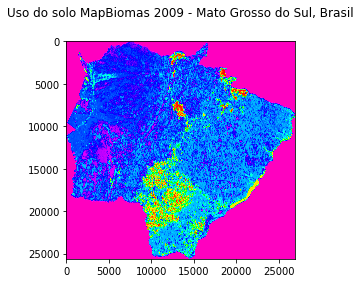

In [8]:
plt.imshow(dataset.read(1), cmap='gist_rainbow_r',)
plt.title('Uso do solo MapBiomas 2009 - Mato Grosso do Sul, Brasil',pad = 25)
plt.show()

Filtrando 3 municípios de MS de um arquivo de municípios nacionais. Selvíria, Água Clara e Três Lagoas.

In [9]:
Fileshape = "/content/drive/MyDrive/Databases/LimitesMunicipais/lim_municipio_a.shp" #Local onde está o arquivo de consulta

In [10]:
municipios = gp.read_file(Fileshape)

In [11]:
municipios.columns

Index(['nome', 'nomeabrev', 'geometriaa', 'geocodigo', 'anoderefer',
       'id_produto', 'id_element', 'geometry'],
      dtype='object')

In [12]:
with fiona.open(Fileshape) as poligonshape: #Carregando arquivo de municípios.
    filtered = filter(lambda f: f['properties']['nome']=='Selvíria' or f['properties']['nome']=='Água Clara' or f['properties']['nome']=='Três Lagoas' , poligonshape)
    shapes = [feature["geometry"] for feature in filtered]

Criando função para cortar a imagem

In [13]:
def ClipRaster(FionaPolygon,TifImage,OutputImage):
  with rasterio.open(TifImage) as src: #Abro uma imagem e a limito pela extensão do poligono
    out_image, out_transform = rasterio.mask.mask(src, FionaPolygon, crop=True)#Delimito a imagem pelo poligono atribuido
    out_meta = src.meta #repasso os metadados da imagem para a nova imagem cortada
  out_meta.update({"driver": "GTiff","height": out_image.shape[1],"width": out_image.shape[2],"transform": out_transform})
  with rasterio.open(OutputImage, "w", **out_meta) as dest: #Salvo a nova imagem delimitada
    dest.write(out_image)


Processando o corte das imagens com a função "ClipRaster"

In [14]:
#Nome e local dos arquivos de imagens cortados
ClipedImage2009 = "ClipedImage2009.tif"
ClipedImage2019 = "ClipedImage2019.tif"
#Procesando imagens
ClipRaster(shapes,MapBiomas2009MS,ClipedImage2009)
ClipRaster(shapes,MapBiomas2019MS,ClipedImage2019)

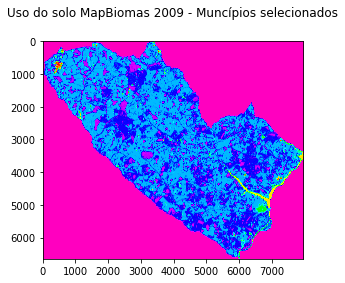

In [15]:
# Carrego a imagem delimitada e mostro na tela na tela
studyAreaImage2019 = rasterio.open(ClipedImage2019)
plt.imshow(studyAreaImage2019.read(1), cmap='gist_rainbow_r',)
plt.title('Uso do solo MapBiomas 2009 - Muncípios selecionados',pad = 25)
plt.show()

###Criando amostras de NDVI de florestas plantadas

####Transformando imagens em polígonos

Função para transformar um raster (arquivo matricial) em poligonos.

In [16]:
def RasterToPolygon (Image,epsg=4326):
  with rasterio.Env(): #Executa os comandos em seu interior em um ambiente de configuração isolada.
    with rasterio.open(Image,"r+") as src: #Abro a imagem
        src.nodata = 0 #Defino que o valor de pixel que corresponde a valores nulos nesse caso é o 0
        mask = src.read_masks(1) #Lê uma máscara da imagem, basicamente os locais onde a imagem é nula
        image = src.read(1) # Lê a banda 1 da imagem. Imagens RGB por exemplo tem três bandas (Red, Green e Blue).
        results = ( #Criando uma variável pra receber as informações
        {'properties': {'raster_val': v}, 'geometry': s} #Defindo as propriededes desse arquivo. Nesse caso as coordenadas dos poligonos e o valor que representava seus pixels
        for i, (s, v) in enumerate(rasterio.features.shapes(image, mask=mask, transform=src.transform)) # Aplica para cada valor de pixel diferente a função para converter o raster em vetor que representa o pixel desse valor
        )

  geoms = list(results)
  gpd_polygonized_raster = gp.GeoDataFrame.from_features(geoms) #Cria um dataset de geometrias/poligonos no geopandas
  gpd_polygonized_raster = gpd_polygonized_raster.set_crs(epsg=epsg) #Atribui o sistema de referência de coordenadas
  return gpd_polygonized_raster

Usando a função de conversão de arquivos

In [17]:
gpd_polygonized_raster2019 = RasterToPolygon(ClipedImage2019)
gpd_polygonized_raster2009 = RasterToPolygon(ClipedImage2009)


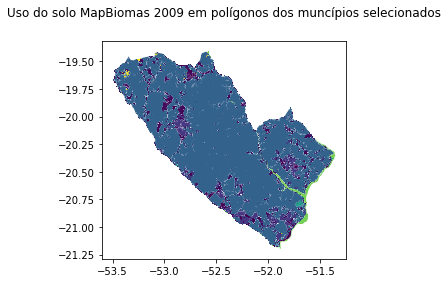

In [18]:
gpd_polygonized_raster2009.plot(column='raster_val')
plt.title('Uso do solo MapBiomas 2009 em polígonos dos muncípios selecionados',pad = 25)
plt.show()

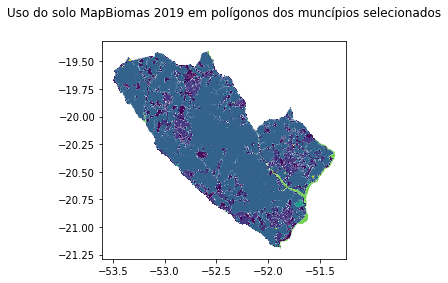

In [19]:
gpd_polygonized_raster2019.plot(column='raster_val')
plt.title('Uso do solo MapBiomas 2019 em polígonos dos muncípios selecionados',pad = 25)
plt.show()

####Intersecção de polígonos

Segundo a fonte do dado, o valor que representa floresta plantada é 9. https://mapbiomas-br-site.s3.amazonaws.com/_PT-BR__C%C3%B3digos_da_legenda_Cole%C3%A7%C3%A3o_5.pdf

In [20]:
Forests2019 = gpd_polygonized_raster2019.query('raster_val == 9.0').copy()
Forests2009 = gpd_polygonized_raster2009.query('raster_val == 9.0').copy()

Interseccionando os dos poligonos para selecionar áreas que não tiveram mudandas em 10 anos

In [21]:
intersect = gp.overlay(Forests2019, Forests2009, how='intersection')
# Transformando para sistema de coordenada metrico, para calcular as áreas corretametne. Usando o CSR Brasileiro recomendado para a região de estudo, o Sirgas 2000 22S
intersect = intersect.to_crs(31982) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning:

`keep_geom_type=True` in overlay resulted in 1394 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries



In [22]:
intersect['area']=intersect['geometry'].area #Calculando as áreas
intersectFilter= intersect.query('area > 62500.00').copy() #Filtrando para as áreas maiores que os pixels do satélite.

In [23]:
intersect.head(4)

,raster_val_1,raster_val_2,geometry,area
0,9.0,9.0,"POLYGON ((337135.744 7845875.196, 337135.474 7...",10127.519277
1,9.0,9.0,"POLYGON ((336824.543 7845872.383, 336852.834 7...",843.963243
2,9.0,9.0,"POLYGON ((336628.939 7845602.127, 336628.668 7...",843.953614
3,9.0,9.0,"POLYGON ((336543.526 7845661.017, 336543.796 7...",80176.044511


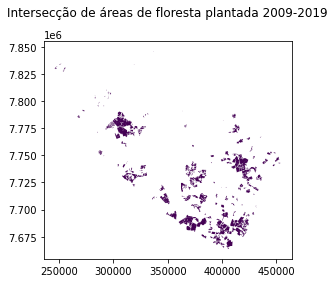

In [24]:
intersectFilter.plot(column='raster_val_1')
plt.title('Intersecção de áreas de floresta plantada 2009-2019',pad = 25)
plt.show()

In [25]:
IntersectFiler = "/content/drive/MyDrive/Databases/IntersectFiler.shp"
intersectFilter.to_file(IntersectFiler)  #Salva em um arquivo na máquina  
Intersect = geemap.shp_to_ee(IntersectFiler) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning:

Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.



####Criando dados pontuais de floresta plantada

Mudando a geometria para centroides

In [26]:
pointsPlantedForest = intersectFilter[ 'geometry'].centroid


Plotando a informação na tela e salvando o arquivo

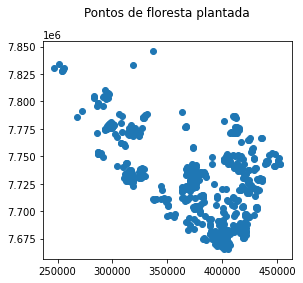

In [27]:
pointsPlantedForest.plot()
plt.title('Pontos de floresta plantada',pad = 25)
PointFiler = "/content/drive/MyDrive/Databases/pointsPlantedForest.shp"
pointsPlantedForest.to_file(PointFiler)  #Salva em um arquivo na máquina  


####Carregando os pontos em um objeto que interage com a API do Google Earth Engine.

In [28]:
Points = geemap.shp_to_ee(PointFiler) 
type(Points)

ee.featurecollection.FeatureCollection

### Delimitando intervalo de imagem da área de estudo

In [29]:
dissolvePoly = intersectFilter.copy() #Faço uma cópia do arquivo intersecsionado.
dissolvePoly= dissolvePoly.dissolve(by='raster_val_1', aggfunc= 'mean') #Dissolvo (ou resumo) os vários poligonos em um só, baseado em um dos atributos tabulares.
dissolvePoly['geometry'] = dissolvePoly['geometry'].envelope #Crio um polígono do tamanho das proporções máximas do polígono dissolvido anteriomente.
dissolvePoly['geometry'] = dissolvePoly['geometry'].buffer(5000)#Aumento esse poligono em 5 km de borda.
FileExtend = "/content/drive/MyDrive/Databases/FileExtend.shp"
dissolvePoly.to_file(FileExtend)  #Salva em um arquivo na máquina  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning:

Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.



Text(0.5, 1.0, 'Limites máximos da área de estudo')

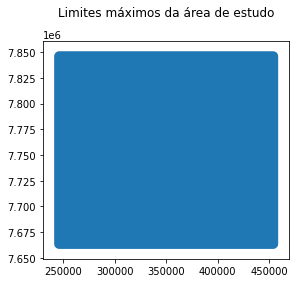

In [30]:
dissolvePoly.plot()
plt.title('Limites máximos da área de estudo',pad = 25)

In [31]:
AOI = geemap.shp_to_ee(FileExtend)

###Avaliando a área de Estudo com imagens Sentinel 2

Intervalo de data

In [32]:
startDateviz = ee.Date.fromYMD(2009,1,1);
endDateviz = ee.Date.fromYMD(2009,3,30);
startDateviz2 = ee.Date.fromYMD(2015,1,1);
endDateviz2 = ee.Date.fromYMD(2015,3,30);
startDateviz3 = ee.Date.fromYMD(2019,1,1);
endDateviz3 = ee.Date.fromYMD(2019,3,30);

In [33]:
#Função para transformar os valores dos pixeis para o intervalo de -1 a 1 em tipo float e inserir a proproedade da data das imagens
def NDVIf(image):
  return image.expression('float(b("NDVI")/10000)').copyProperties(image, ["system:time_start"])

Configurando as imagens para visualização

In [34]:
#Aplico os filtros na coleção de imagens NDVI MODIS, de área, datas e representação de valores do NDVI
modis = ee.ImageCollection("MODIS/006/MOD13Q1")
NDVI_Modis2016 = modis.filterBounds(AOI).filterDate(startDateviz,endDateviz).map(NDVIf)
NDVI_Modis2019 = modis.filterBounds(AOI).filterDate(startDateviz2,endDateviz2).map(NDVIf)

In [35]:
collectionviz = ee.ImageCollection('MODIS/006/MCD43A4').filterDate(startDateviz,endDateviz).filterBounds(AOI)
collectionviz2 = ee.ImageCollection('MODIS/006/MCD43A4').filterDate(startDateviz2,endDateviz2).filterBounds(AOI)
collectionviz3 = ee.ImageCollection('MODIS/006/MCD43A4').filterDate(startDateviz3,endDateviz3).filterBounds(AOI)
S2_2016 = collectionviz.select([ 'Nadir_Reflectance_Band1', 'Nadir_Reflectance_Band4',  'Nadir_Reflectance_Band3'])
S2_2015 = collectionviz2.select([ 'Nadir_Reflectance_Band1', 'Nadir_Reflectance_Band4',  'Nadir_Reflectance_Band3'])
S2_2019 = collectionviz3.select([ 'Nadir_Reflectance_Band1', 'Nadir_Reflectance_Band4',  'Nadir_Reflectance_Band3']) #.median().clip(AOI)

In [36]:
print(S2_2019.size().getInfo())

88


In [37]:
vis_params = {  'min': 0.0,  'max': 4000.0, 'gamma': 1.4  }
ndvi_params = {'min': 0, 'max': 1, 'palette': ['red', 'yellow','green']}

Colocando as imagens e as amostras em  uma visualização, as regiões verdes indicação vegeação e NDVIs altos.

In [38]:
Map = geemap.Map()
Map.addLayer(S2_2016,vis_params,'MODIS - 2009')
Map.addLayer(S2_2015,vis_params,'MODIS - 2015')
Map.addLayer(S2_2019,vis_params,'MODIS - 2019')
Map.addLayer(NDVI_Modis2016,ndvi_params,'NDVI MODIS 2016')
Map.addLayer(NDVI_Modis2019,ndvi_params,'NDVI MODIS 2019')
Map.center_object(Points)
Map.addLayer(Points,name='Amostras')
Map.addLayerControl()
Map

###Extraindo dados de NDVI de imagens MODIS entre Jan-2009 e Dez-2019

In [39]:
#Função para transformar os valores dos pixeis para o intervalo de -1 a 1 em tipo float e 
#inserir a propriedade da data das imagens
def NDVIf(image):
  return image.expression('float(b("NDVI")/10000)').copyProperties(image, ["system:time_start"])

In [40]:
#Definindo o intervalo de data das imagens.
startDate = ee.Date.fromYMD(2009,1,1);
endDate = ee.Date.fromYMD(2019,12,31);

In [41]:
#Aplico os filtros na coleção de imagens NDVI MODIS, de área, datas e 
#representação de valores do NDVI
modis = ee.ImageCollection("MODIS/006/MOD13Q1")
NDVI_Modis = modis.filterBounds(AOI).filterDate(startDate,endDate).map(NDVIf)


Essa função extraí a média dos valores NDVI das imagens disponíveis para o conjunto de pontos de floresta plantada nas datas de obtenção de cada imagem ou conjunto de imagens. Terminando assim o processamento espacial das informações.

In [42]:
#Função do ipygee para obtenção de gráficos derivados de coleção de imagens do GEE
point_ndvi_Modis = chart.Image.series(**{'imageCollection': NDVI_Modis,
                                   'region': Points,
                                   'reducer': ee.Reducer.mean(),
                                   'bands' : 'NDVI',
                                   'scale': 25,
                                   'xProperty': 'system:time_start'})


In [43]:
point_ndvi_Modis.renderWidget(width='40%')

HTML(value='<embed src=data:image/svg+xml;charset=utf-8;base64,PD94bWwgdmVyc2lvbj0nMS4wJyBlbmNvZGluZz0ndXRmLTg…

## Processamento/Tratamento da Série Temporal

In [44]:
#Quantidade de imagens na coleção
print(NDVI_Modis.size().getInfo())

253


In [45]:
#Crio um dataframe pandas com os dados da serie temporal
p1_dataframeModis=point_ndvi_Modis.dataframe
#Salvando métricas para comparativo posterior
moment1=p1_dataframeModis.describe()

In [46]:
p1_dataframeModis.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 253 entries, 2009-01-01 to 2019-12-19
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   NDVI    253 non-null    float64
dtypes: float64(1)
memory usage: 4.0 KB


Plotando a série temporal

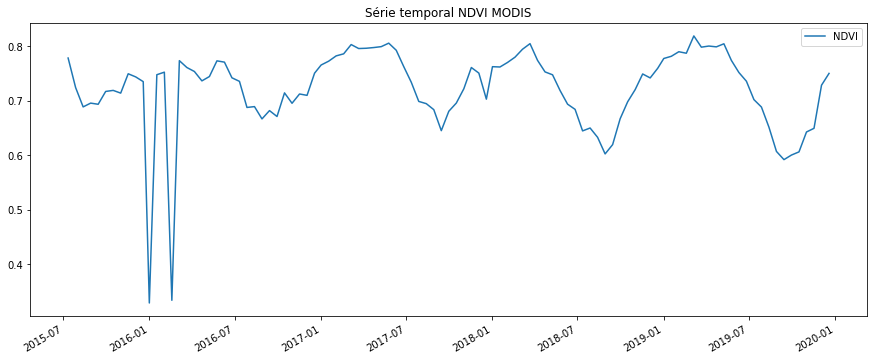

In [47]:
p1_dataframeModis[150:].plot(figsize=(15, 6))
plt.title('Série temporal NDVI MODIS')
plt.legend(loc='best')
plt.show()


Avaliando outliers

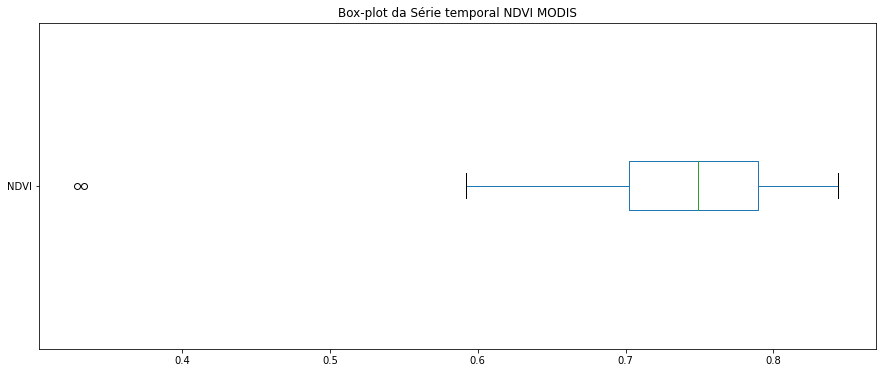

In [48]:
p1_dataframeModis.plot(figsize=(15, 6),kind='box',vert=False)
plt.title('Box-plot da Série temporal NDVI MODIS')
plt.show()

Eliminando outliers

In [49]:
p1_dataframeModis = p1_dataframeModis[p1_dataframeModis['NDVI']>0.5]

In [50]:
moment2 = p1_dataframeModis.describe()
moment2['NDVI2']=moment1['NDVI']


In [51]:
moment2.columns=["NDVI sem outliers","NDVI com outliers"]
moment2.columns
moment2

,NDVI sem outliers,NDVI com outliers
count,251.000000,253.000000
mean,0.743763,0.740503
std,0.054411,0.065387
min,0.591763,0.329014
25%,0.704644,0.702635
50%,0.749273,0.749181
75%,0.789774,0.789567
max,0.843771,0.843771


##Avaliando a recorrência do dado

In [52]:
p1_dataframeModis.reset_index(inplace=True)
p1_dataframeModis['rec']=0
p1_dataframeModis.columns=["date","NDVI","rec"]
p1_dataframeModis.head(2)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,date,NDVI,rec
0,2009-01-01,0.69236,0
1,2009-01-17,0.70363,0


In [53]:
#Contando dias entre as imagens
i=1
while i <= len(p1_dataframeModis)-1:
  p1_dataframeModis['rec'][i]=(p1_dataframeModis['date'][i]-p1_dataframeModis['date'][i-1]).days
  i += 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [54]:
p1_dataframeModis.groupby('rec').count().drop(columns=['date'])

,NDVI
rec,
0,1
13,7
14,2
16,239
29,1
32,1


In [55]:
p1_dataframeModis = p1_dataframeModis.set_index('date')


In [56]:
p1_dataframeModis=p1_dataframeModis.drop(columns=['rec'])

Interpolando os dados para uma frequência diária

In [57]:
moving_averageModis = p1_dataframeModis['NDVI'].rolling(window=3).mean()
moving_averageModis = pd.DataFrame(moving_averageModis).dropna()
upsampled = moving_averageModis.resample('D')
interpolated_dataframe = upsampled.interpolate(method='time')
interpolated_dataframe.describe()

,NDVI
count,3973.000000
mean,0.744065
std,0.051441
min,0.599310
25%,0.707190
50%,0.748368
75%,0.788653
max,0.833152


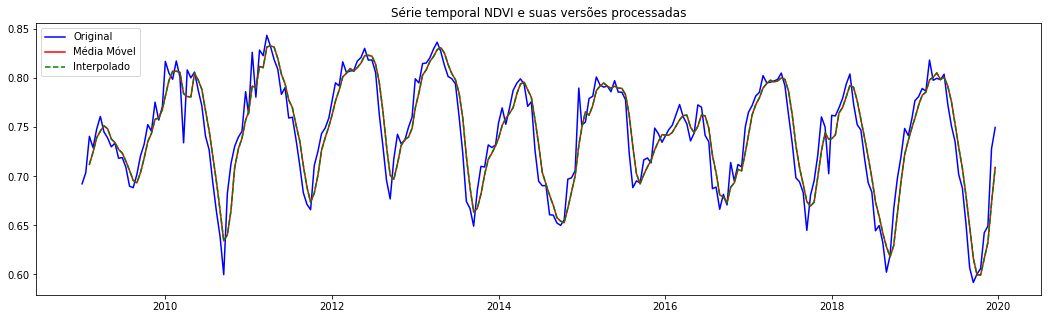

In [58]:
rcParams['figure.figsize'] = 18, 5
orig = plt.plot(p1_dataframeModis, color='blue',label='Original')
meanMoving = plt.plot(moving_averageModis, color='red', label='Média Móvel')
inter = plt.plot(interpolated_dataframe, color='green', label='Interpolado',ls='--')
plt.title('Série temporal NDVI e suas versões processadas')
plt.legend(loc='best')

#Análise e Exploração dos Dados

## Decomposição sazonal

Uma série temporal possui alguns componentes importantes para sua descrição, que são o nível, a tendência, a sazonalidade e o ruído, onde respectivamente representam o valor médio da série, tendências positivas e negativas da série, o os ciclos da série e a variação aleatória da série.

A série temporal deste trabalho é uma representação da fisiologia de plantas, ela acompanha a sazonalidade das estações do ano, por isso faremos uma decomposição de sazonalidade aditiva (indicada para variação sazonal constante) em um período anual, isto é, 365 dias (linhas).

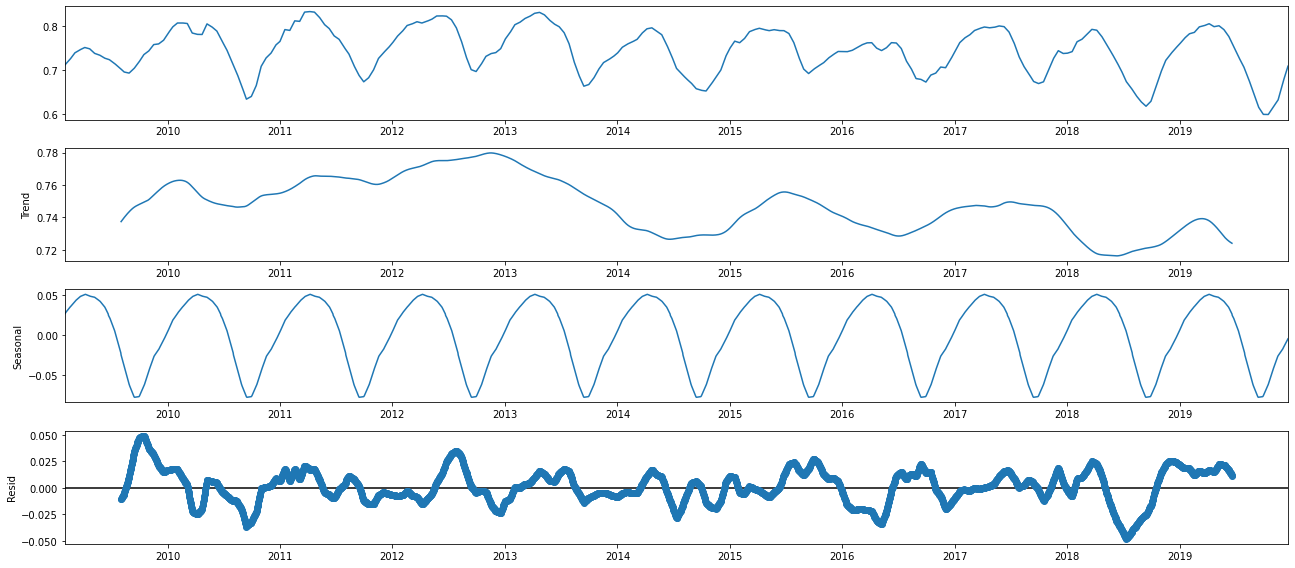

In [59]:
rcParams['figure.figsize'] = 18, 8


decomposition = sm.tsa.seasonal_decompose(interpolated_dataframe, model='additive',period=365)

fig = decomposition.plot()
plt.show()

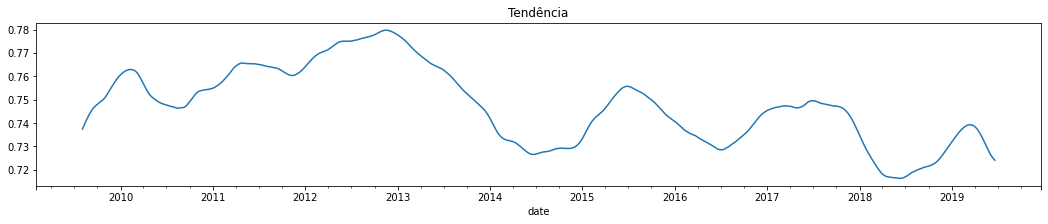

In [60]:
rcParams['figure.figsize'] = 18, 3
plt.title('Tendência')
decomposition.trend.plot()


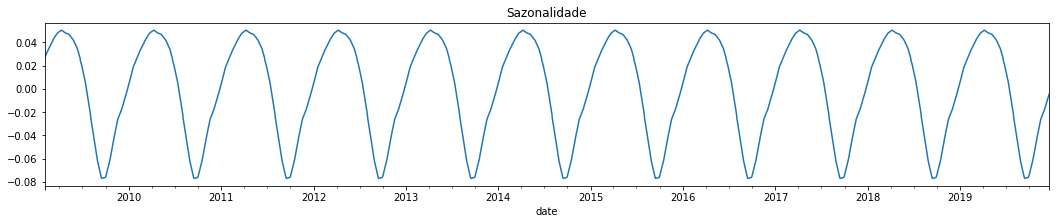

In [61]:
plt.title('Sazonalidade')
decomposition.seasonal.plot()

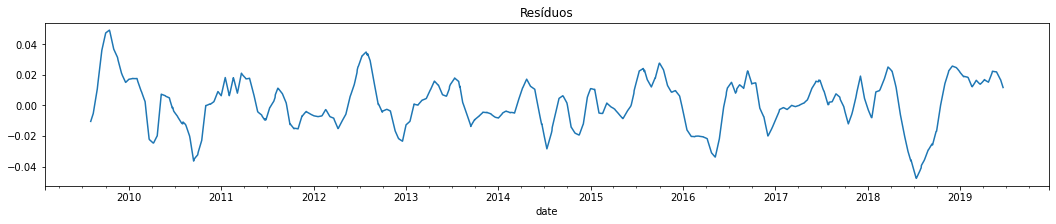

In [62]:
plt.title('Resíduos')
decomposition.resid.plot()


##Teste de estacionaridade

In [63]:
# Testando estacionaridade, para p < 0,05 é considerado estacionário 
X = interpolated_dataframe['NDVI']
result = adfuller(X)
print('ADF Estatíticas: %f' % result[0])
print('Valor de P: %f' % result[1])
print('Valores Críticos:')
for key, value in result[4].items():
   print('\t%s: %.3f' % (key, value))

ADF Estatíticas: -7.384430
Valor de P: 0.000000
Valores Críticos:
	1%: -3.432
	5%: -2.862
	10%: -2.567


##Autocorrelação da média móvel

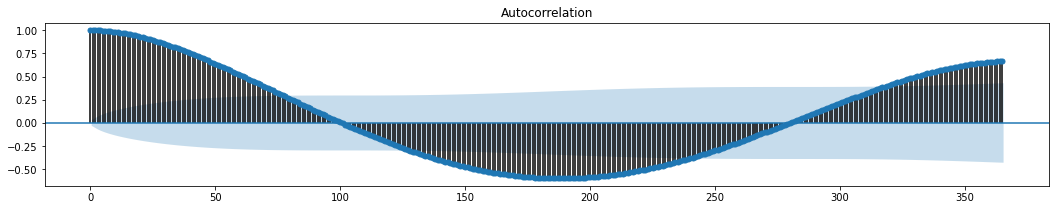

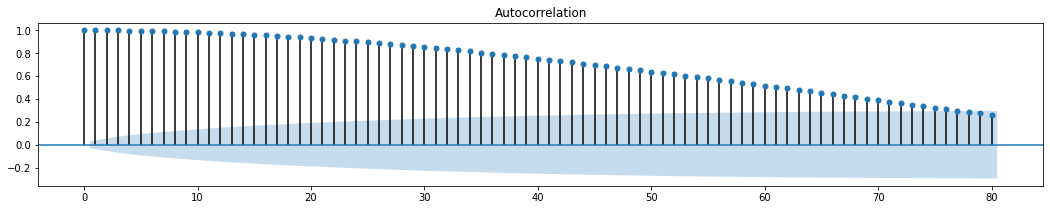

In [64]:
plot_acf(interpolated_dataframe,lags=365)
plot_acf(interpolated_dataframe,lags=80)
plt.show()


##Histograma

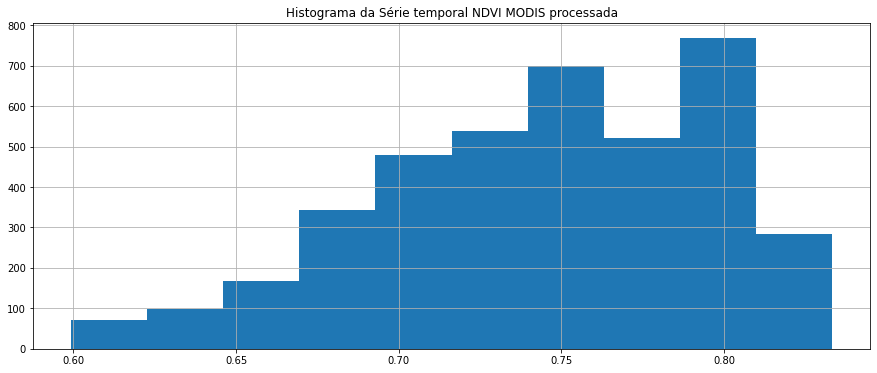

In [65]:
interpolated_dataframe['NDVI'].hist(figsize=(15, 6))
plt.title('Histograma da Série temporal NDVI MODIS processada')
plt.show()

##Boxplot 

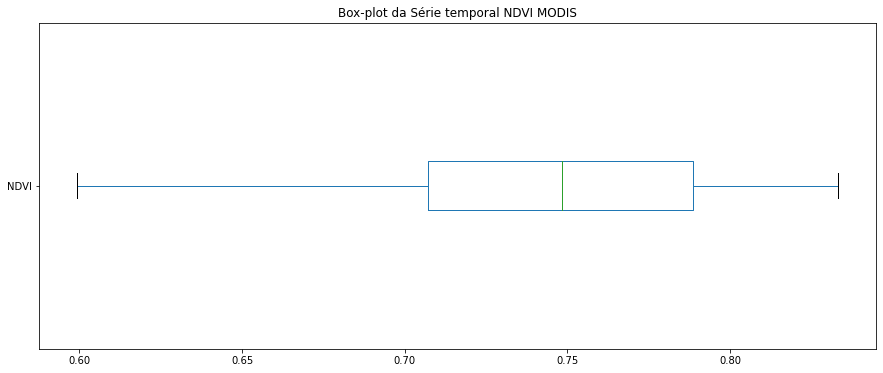

In [66]:
interpolated_dataframe.plot(figsize=(15, 6),kind='box',vert=False)
plt.title('Box-plot da Série temporal NDVI MODIS')
plt.show()

#Modelagem

Divide Data in Train and Valid

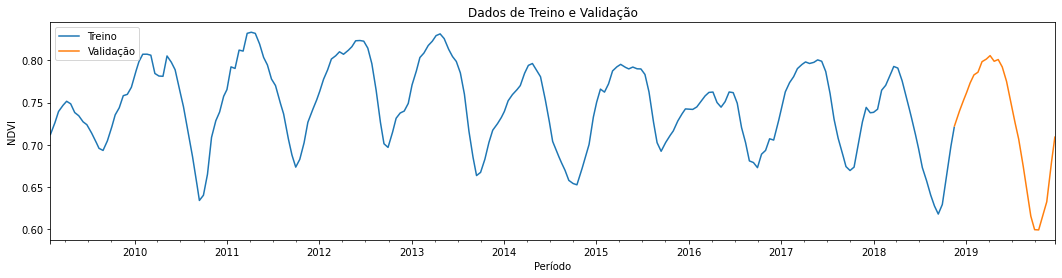

In [67]:
train = interpolated_dataframe[:int(0.90*(len(interpolated_dataframe)))]
valid = interpolated_dataframe[int(0.90*(len(interpolated_dataframe))):]

#plotting the data
rcParams['figure.figsize'] = 18, 4
train['NDVI'].plot(label = "Treino")
valid['NDVI'].plot(label = "Validação")
plt.title('Dados de Treino e Validação')
plt.xlabel("Período")
plt.ylabel("NDVI")
plt.legend(loc='best')

In [68]:
print("Treino com ", train['NDVI'].count()," valores e validação com",valid['NDVI'].count())

Treino com  3575  valores e validação com 398


## ARIMA e Auto ARIMA


O ARIMA é um método que modela as etapas subsequentes de uma série com uma função linear das observações diferenciadas e erros residuais em etapas de tempo anteriores. Esse método é a combinação de outros três processos,  modelos de Autorregressão (AR) e Média Móvel (MA) e também uma etapa de pré-processamento de diferenciação da sequência para tornar a série estacionária, chamada integração (I), esses três processos também resume os três principais parâmetros da modelagem:



> p: O número de lags que foram devem ser incluídos no modelo (AR).

> d: O número de vezes que as observações serão diferenciadas ( I ).

> q: O tamanho de uma janela de média móvel. Também chamada de ordem de média móvel (MA).
  
  Normalmente os parâmetros “p”, “d” e “q” são definidos através de técnicas estatísticas, porém com um Auto ARIMA o próprio modelo fica responsável por otimizar a escolha desses parâmetros para fornecer a melhor previsão para o conjunto de dados. Além desses parâmetros principais algumas outras configurações podem ser aplicadas para melhorar o desempenho do modelo, conforme se vê abaixo.

In [69]:
model_A_A = pm.auto_arima(train, 
                          error_action='ignore', 
                          trace=True,           #Lista os modelos testados
                          suppress_warnings=True, 
                          maxiter=50,
                          seasonal=True,        #Sazonalidade
                          m=12,                 # Frequência da série
                          start_p=5,start_q=3,  #Valores iniciais de 'p' e 'q'  para serem testados
                          stationary = True,    #Define que é uma série estacionária conforme vimos no teste ADF
                          d=0,                  #Define 'd' como 0, ou seja, não aplica diferenciação
                          stepwise=True,        #Fará uma selação gradual dos modelos
                          max_order =10,
                          max_p =10,max_q =10,  # Valores máximos de teste para 'p' e 'q'
                          max_P =4,max_Q =4     # Valores máximos de teste para 'P' e 'Q' Sazonais
                          )
model_A_A.fit(train)

Performing stepwise search to minimize aic
 ARIMA(5,0,3)(1,0,1)[12] intercept   : AIC=-49448.254, Time=60.90 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-11484.195, Time=0.51 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=5.73 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=10.57 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=8069.007, Time=0.14 sec
 ARIMA(5,0,3)(0,0,1)[12] intercept   : AIC=-52042.071, Time=14.57 sec
 ARIMA(5,0,3)(0,0,0)[12] intercept   : AIC=-52044.071, Time=6.19 sec
 ARIMA(5,0,3)(1,0,0)[12] intercept   : AIC=-49421.228, Time=56.02 sec
 ARIMA(4,0,3)(0,0,0)[12] intercept   : AIC=-52046.344, Time=7.93 sec
 ARIMA(4,0,3)(1,0,0)[12] intercept   : AIC=-49452.264, Time=47.02 sec
 ARIMA(4,0,3)(0,0,1)[12] intercept   : AIC=-52044.344, Time=13.80 sec
 ARIMA(4,0,3)(1,0,1)[12] intercept   : AIC=-49423.607, Time=36.09 sec
 ARIMA(3,0,3)(0,0,0)[12] intercept   : AIC=-52048.486, Time=4.39 sec
 ARIMA(3,0,3)(1,0,0)[12] intercept   : AIC=-49442.128, Time=57.58 sec

ARIMA(order=(2, 0, 1), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True)

In [70]:
model_A_A.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3575
Model:               SARIMAX(2, 0, 1)   Log Likelihood               26036.072
Date:                Sun, 01 Aug 2021   AIC                         -52062.143
Time:                        20:19:20   BIC                         -52031.235
Sample:                             0   HQIC                        -52051.124
                               - 3575                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0003    4.5e-05      6.566      0.000       0.000       0.000
ar.L1          1.9851   3.03e-05   6.55e+04      0.000       1.985       1.985
ar.L2         -0.9855   3.03e-05  -3.25e+04      0.000      -0.986      -0.985
ma.L1         -0.0056   2.45e-08  -2.28e+05      0.000      -0.006      -0.006
sigma2      2.751e-08   1.63e-10    168.673      0.000    2.72e-08    2.78e-08
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            422135.69
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.69   Skew:                             1.40
Prob(H) (two-sided):                  0.00   Kurtosis:                        56.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.57e+22. Standard errors may be unstable.
"""

In [71]:
pred_A_A = model_A_A.predict(n_periods=len(valid))

## Prophet

  O Prophet é uma ferramenta para prever dados de séries temporais, tem como bases modelos aditivos e multiplicativos onde tendências não lineares podem ser ajustadas em sazonalidades anuais, semanais e diárias. Ele funciona bem em séries temporais que têm fortes efeitos sazonais como é o caso dos dados de NDVI.

  A entrada para o Prophet deve ser um dataframe com duas colunas, a coluna “ds” para marcação de tempo que deve ter um formato esperado pelo Pandas e a coluna “y” deve ser a representação numérica daquilo que desejamos prever. 

  O Prophet tem a característica de ser marcado pela identificação de pontos de mudança significativa nos dados, eles são definidos automaticamente ou parametrizados. Parametrizações de sazonalidade também são aceitáveis para obter melhores resultados.

Transformando dados de treino e teste em formato compativel com o Prophet

In [72]:
train_prophet = pd.DataFrame()
train_prophet['ds'] = train.index
train_prophet['y'] = train.NDVI.values

valid_prophet = pd.DataFrame()
valid_prophet['ds'] = valid.index
valid_prophet['y'] = valid.NDVI.values

Criando o modelo e treinando

In [73]:
model_Prophet=Prophet(
                      changepoint_range=0.10,   #Define o intervalo dos dados de treinamento que serão utilizados 				 
                                               #para rastrear pontos de mudança , foi aplicado aqui 10% dos dados
                                               #considerando a sazonalidade anual.
                      daily_seasonality=False, #Define que os dados não tem sazonalidade diária.
                      yearly_seasonality=True  #Define que os dados tem sazonalidade anual.
                      )
model_Prophet.fit(train_prophet)

Fazendo a previsão e validação

In [74]:
forecast_d =(valid.index[-1]-valid.index[0]).days

In [75]:
future = model_Prophet.make_future_dataframe(periods = forecast_d, freq = 'D')

In [76]:
predictions = model_Prophet.predict(future)

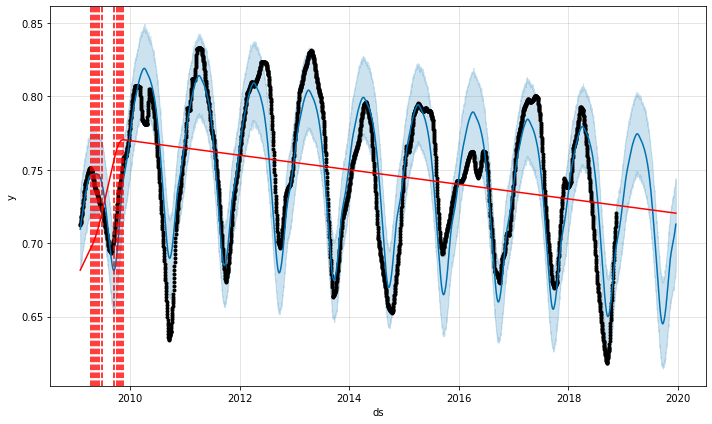

In [77]:
#Avaliando pontos de mudança
from fbprophet.plot import add_changepoints_to_plot
fig = model_Prophet.plot(predictions)
a = add_changepoints_to_plot(fig.gca(), model_Prophet, predictions)


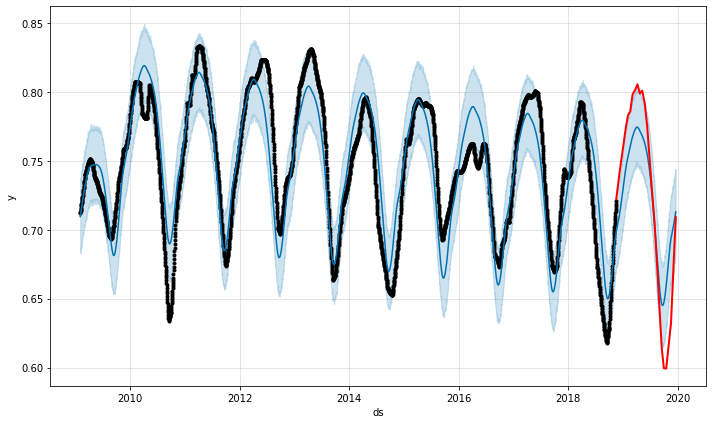

In [78]:
fig = model_Prophet.plot(predictions)
plt.plot(valid, label='Valid', color = 'red', linewidth = 2)
plt.show()

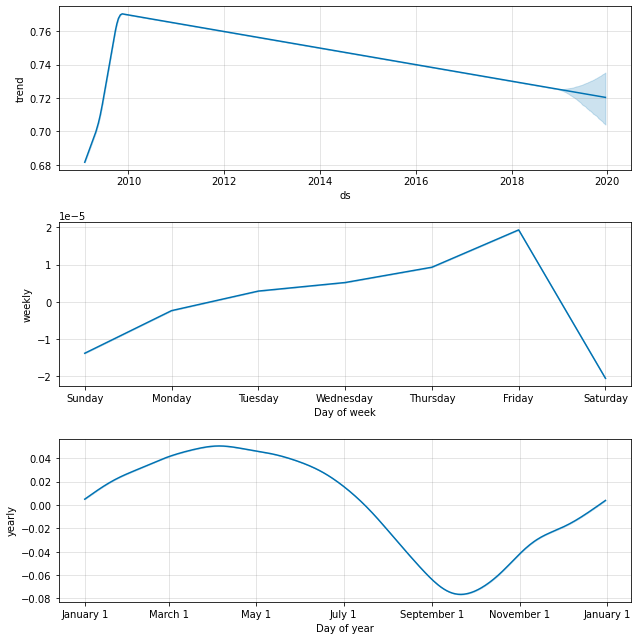

In [79]:
model_Prophet.plot_components(predictions);

In [80]:
pred = predictions[predictions.ds.isin(valid.index)]

##LSTM

A LSTM (Long short-term memory) é um modelo de rede neural baseado em neurônios voltados para o aprendizado dos dados considerando a influência dos eventos recentes (memória de curto prazo) e dos eventos significativos da série como um todo.

A preparação dos dados é baseada na quantidade de eventos do passado que se quer considerar para o curto prazo de forma que os “n” eventos anteriores (X) ao evento atual(y) influenciam seu resultado.

In [81]:
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

Função para criar o dataset de treino, colocando um um valor futuro em função de uma quantidade de lags de treino

In [82]:
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		end_ix = i + n_steps
		if end_ix > len(sequence)-1:
			break
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

Aplica a função que prepara o dataset para o LSTM

In [83]:
# Escolhendo a quantidade de eventos anteriores
n_steps = 3
# Controi o dataset para o modelo através de um função
X,y = split_sequence(train.values,n_steps)

In [84]:
# resumir os dados
for i in range(4):
	print(X[i], y[i])

[[0.71225178]
 [0.7130184 ]
 [0.71378502]] [0.71455164]
[[0.7130184 ]
 [0.71378502]
 [0.71455164]] [0.71531826]
[[0.71378502]
 [0.71455164]
 [0.71531826]] [0.71608487]
[[0.71455164]
 [0.71531826]
 [0.71608487]] [0.71685149]


In [85]:
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))


Criando o modelo

Foi considerada a construção de um modelo Sequencial, com uma camada de 10 unidades LSTM e outra camada de saída. Nossa série é univariada, então o número de recursos em  “n_features” é um, junto com o número de eventos definidos na função “split_sequence”. 	A compilação foi realizada com o amplamente recomendado otimizador “Adam” e como função de perda o erro MSE (Mean Squared Error) que também adequada para regressões.


In [86]:
model = Sequential()
model.add(LSTM(
        units =10, 
        input_shape=(n_steps, n_features)
        ))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

Treinando o modelo

In [87]:
model.fit( X, y, epochs=50, verbose=0)


Fazendo a previsão

In [88]:
A,b = split_sequence(valid.values,n_steps)
r=A[0].reshape((1, n_steps, n_features))

In [89]:
predictionsLSTM = list()
for i in range(len(A)):
	# make one-step forecast
	r, t = A[i].reshape((1, n_steps, n_features)), A[i, -1]
	yhat = model.predict(r,verbose=0)
	# store forecast
	predictionsLSTM.append(yhat[0,0])

#Resultados

Criando tabela para guardar as metricas e função para armazenar os valores na tabela

In [90]:
ResultsMetrics = pd.DataFrame(data = {'Model': ['Model'],
                                      'R2_score': [1.0],
                                      'MAE':[1.0],
                                      'MSE': [1.0],
                                      'RMSE':[1.0]})
ResultsMetrics = ResultsMetrics.drop([0])

In [91]:
def MetricsTable(df,Model,R2_score,	MAE,	MSE,	RMSE):
  df.loc[len(df.index)] = [Model, R2_score, MAE,MSE,RMSE]  
  return df

Colocando Index nas previsões

In [92]:

predictionAA = pd.DataFrame(pred_A_A,index=valid.index)
predictionAA.columns=['predicted_ndvi']

predictionPhophet = pd.DataFrame(pred.yhat.values,index=valid[:-1].index)
predictionPhophet.columns=['predicted_ndvi']

predictionsLSTM = pd.DataFrame(predictionsLSTM,index=valid[:-3].index)
predictionsLSTM.columns=['predicted_ndvi']

Calculando Métricas

In [93]:
#Métricas Auto ARIMA
R2_score_Auto_arima =r2_score(valid.values, pred_A_A)
MAE_Auto_arima      =mean_absolute_error(valid.values, pred_A_A)
MSE_Auto_arima      =mean_squared_error(valid.values, pred_A_A)
RMSE_Auto_arima     =mean_squared_error(valid.values, pred_A_A, squared=False)

ResultsMetrics = MetricsTable(ResultsMetrics,'Auto ARIMA',R2_score_Auto_arima,MAE_Auto_arima,MSE_Auto_arima,RMSE_Auto_arima)



In [94]:
#Métricas Prophet
R2_score_Prophet  = r2_score(valid[:-1].values, pred.yhat.values)
MAE_Prophet       = mean_absolute_error(valid[:-1].values, pred.yhat.values)
MSE_Prophet       = mean_squared_error(valid[:-1].values, pred.yhat.values)
RMSE_Prophet      = mean_squared_error(valid[:-1].values, pred.yhat.values, squared=False)

ResultsMetrics = MetricsTable(ResultsMetrics,'Prophet',R2_score_Prophet,MAE_Prophet,MSE_Prophet,RMSE_Prophet)

In [95]:
#Métricas LSTM
R2_score_LSTM  = r2_score(valid[:-3], predictionsLSTM)
MAE_LSTM       = mean_absolute_error(valid[:-3], predictionsLSTM)
MSE_LSTM       = mean_squared_error(valid[:-3], predictionsLSTM)
RMSE_LSTM      = mean_squared_error(valid[:-3], predictionsLSTM, squared=False)

ResultsMetrics = MetricsTable(ResultsMetrics,'LSTM',R2_score_LSTM,MAE_LSTM,MSE_LSTM,RMSE_LSTM)

##Métrica de desempenho

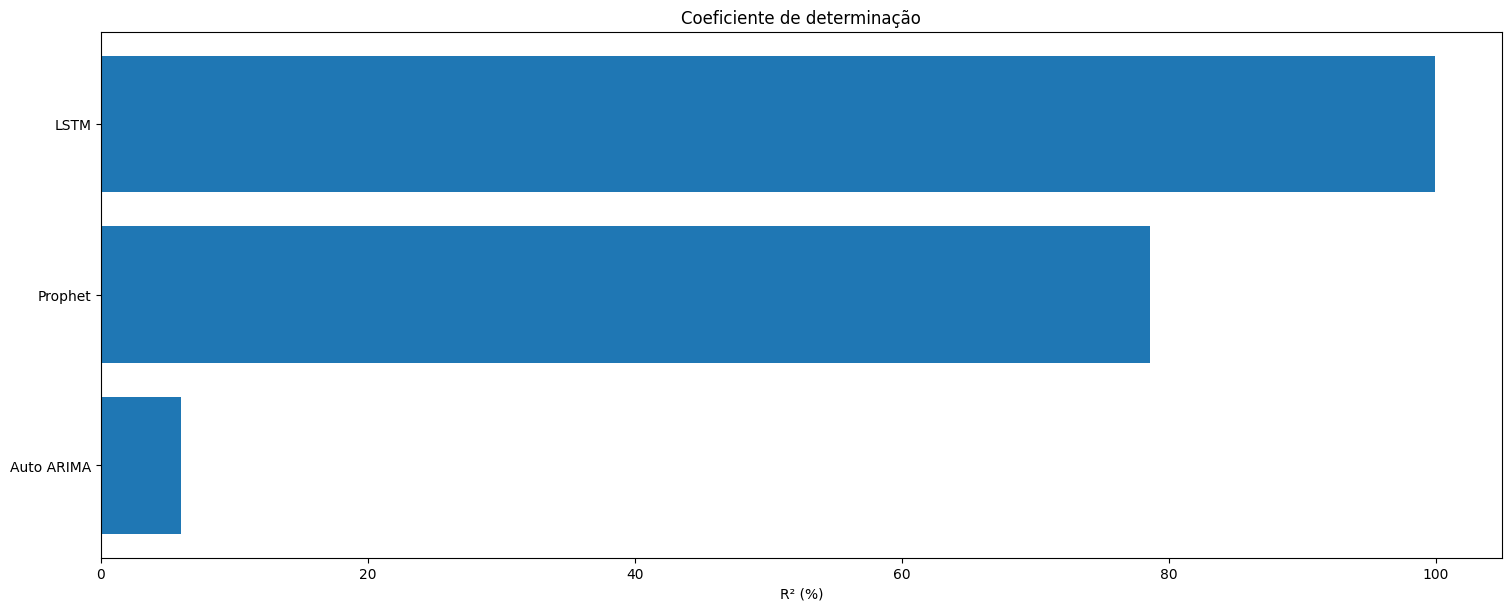

In [96]:
plt.rcdefaults()
fig, ax = plt.subplots(ncols=1,constrained_layout=True,figsize=(15, 6))
ModelsName = ResultsMetrics['Model']
y_pos = np.arange(len(ResultsMetrics))
ax.barh(y_pos, ResultsMetrics['R2_score']*100, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(ModelsName)
ax.set_xlabel('R² (%)')
ax.set_title('Coeficiente de determinação')
plt.show()

In [97]:
#Parametrizando plotagens
matplotlib.rcParams['axes.labelsize'] = 20
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 15
matplotlib.rcParams['text.color'] = 'k'
matplotlib.rcParams['figure.figsize'] = 15, 5
plt.style.use('fivethirtyeight')

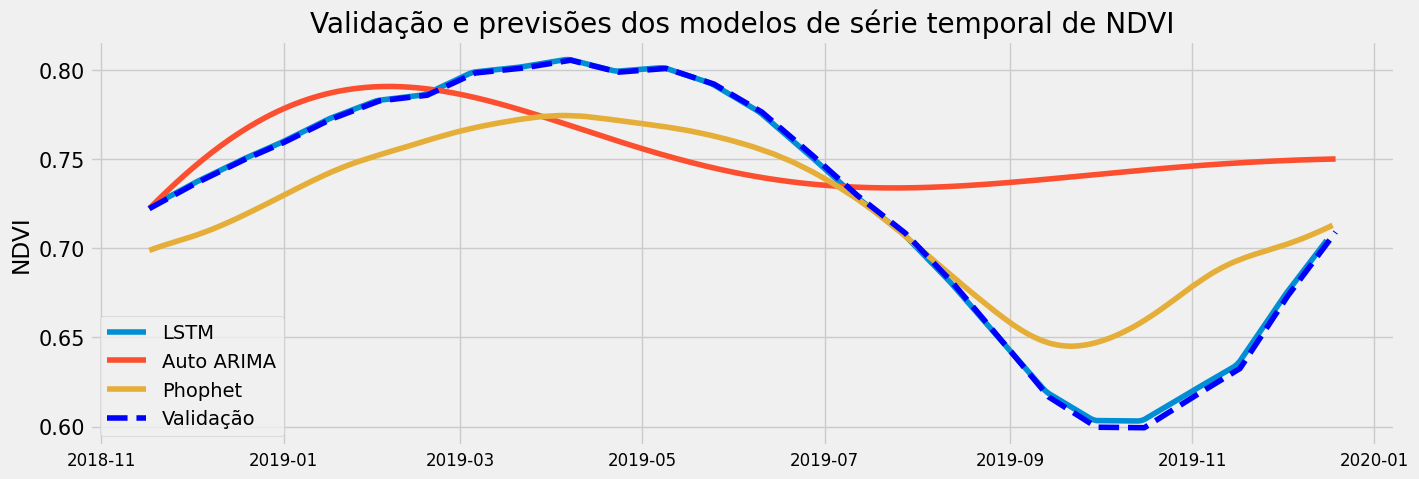

In [98]:
plt.plot(predictionsLSTM[1:], label='LSTM')
plt.plot(predictionAA, label='Auto ARIMA')
plt.plot(predictionPhophet, label='Phophet')
plt.plot(valid,label='Validação',linestyle ='--',color='blue')
plt.title('Validação e previsões dos modelos de série temporal de NDVI')
plt.ylabel("NDVI")
plt.legend(loc='best')
plt.show()

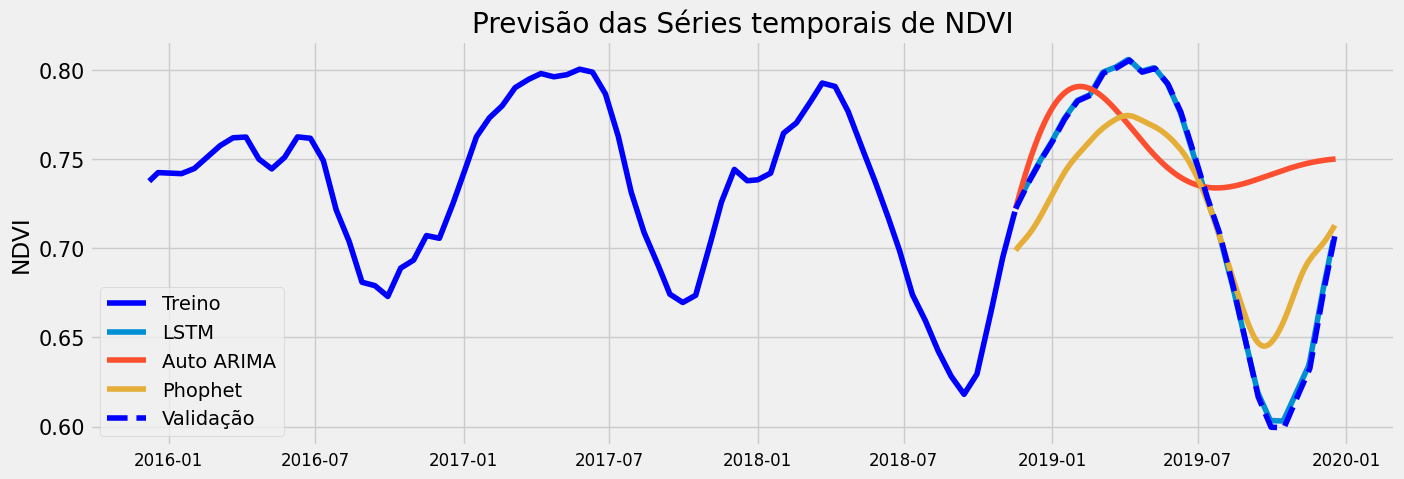

In [99]:
plt.plot(train[2500:],label='Treino',color='blue')
plt.plot(predictionsLSTM[1:], label='LSTM')
plt.plot(predictionAA, label='Auto ARIMA')
plt.plot(predictionPhophet, label='Phophet')
plt.plot(valid,label='Validação',linestyle ='--',color='blue')
plt.title('Previsão das Séries temporais de NDVI')
plt.ylabel("NDVI")
plt.legend(loc='best',)
plt.show()


##Métricas de Erro

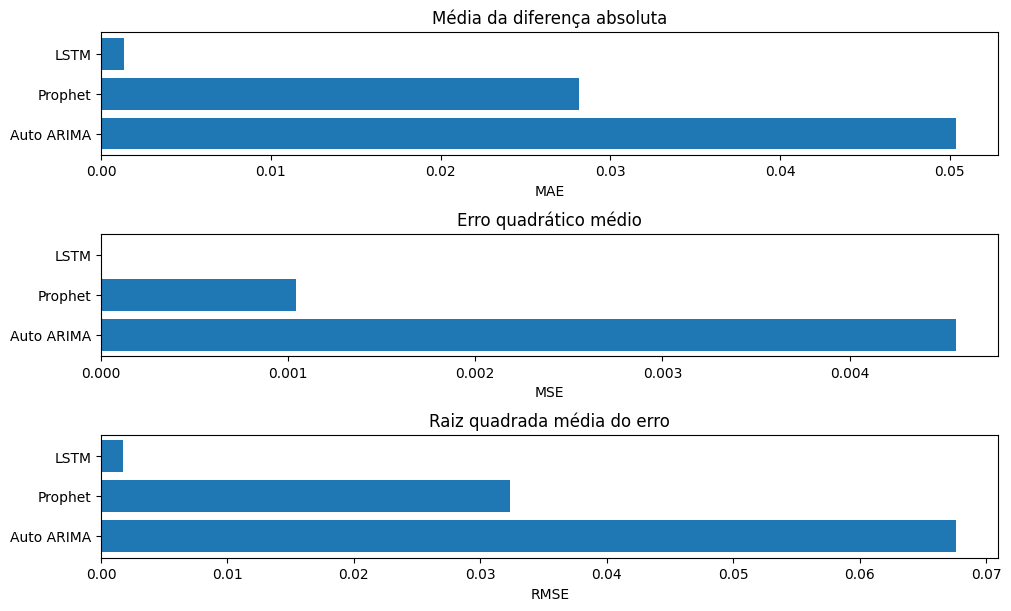

In [100]:
plt.rcdefaults()
fig, ax = plt.subplots(nrows=3,constrained_layout=True, figsize=(10, 6))



ModelsName = ResultsMetrics['Model']
y_pos = np.arange(len(ResultsMetrics))


ax[0].barh(y_pos, ResultsMetrics['MAE'], align='center')
ax[0].set_yticks(y_pos)
ax[0].set_yticklabels(ModelsName)
ax[0].set_xlabel('MAE')
ax[0].set_title('Média da diferença absoluta')

ax[1].barh(y_pos, ResultsMetrics['MSE'], align='center')
ax[1].set_yticks(y_pos)
ax[1].set_yticklabels(ModelsName)
ax[1].set_xlabel('MSE')
ax[1].set_title('Erro quadrático médio')

ax[2].barh(y_pos, ResultsMetrics['RMSE'], align='center')
ax[2].set_yticks(y_pos)
ax[2].set_yticklabels(ModelsName)
ax[2].set_xlabel('RMSE')
ax[2].set_title('Raiz quadrada média do erro')

plt.show()

Calculando residuos

In [101]:
residualsAA = pd.DataFrame([valid.values[i] - predictionAA.values[i] for i in range(len(valid))])
residualsAA.columns=['Erro Auto ARIMA']

valid_p = valid[0:-1]
residualsPhophet = pd.DataFrame([valid_p.values[i] - predictionPhophet.values[i] for i in range(len(valid_p))])
residualsPhophet.columns=['Erro Phophet']

residualsLSTM = pd.DataFrame([valid[:-3].values[i] - predictionsLSTM.values[i] for i in range(len(valid[:-3]))])
residualsLSTM.columns=['Erro LSTM']

In [102]:
#Parametrizando plotagens
matplotlib.rcParams['axes.labelsize'] = 20
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 15
matplotlib.rcParams['text.color'] = 'k'
matplotlib.rcParams['figure.figsize'] = 15, 5
plt.style.use('fivethirtyeight')

Text(0, 0.5, '')

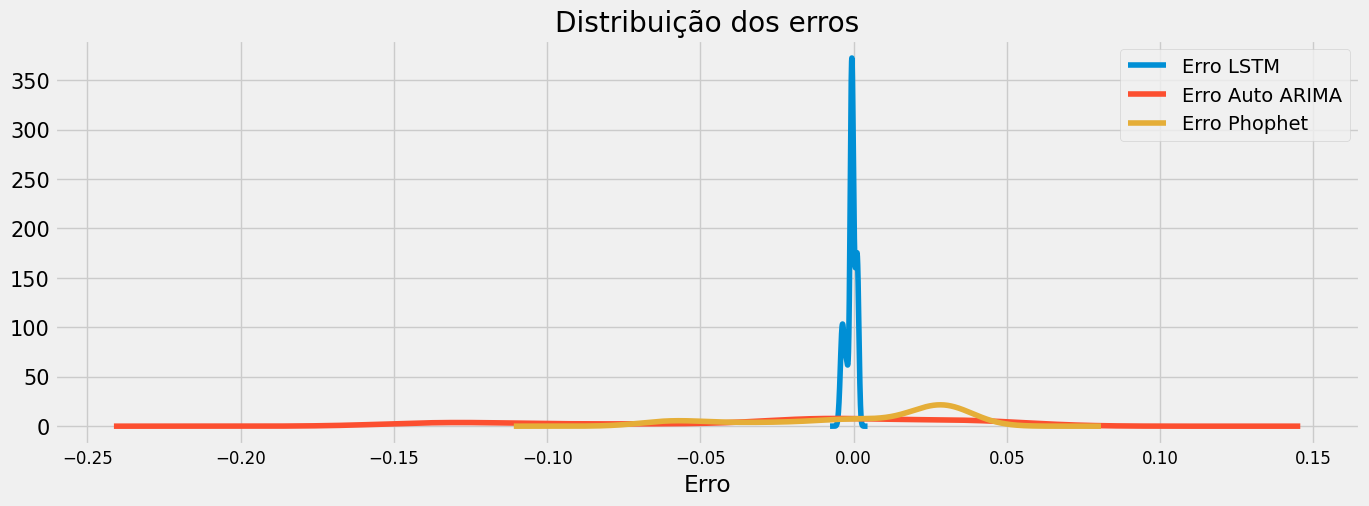

In [103]:
residualsLSTM.plot(kind='kde',ax=plt.gca())
residualsAA.plot(kind='kde',ax=plt.gca())
residualsPhophet.plot(kind='kde',ax=plt.gca())
plt.title('Distribuição dos erros')
plt.xlabel("Erro")
plt.ylabel("")

Text(0.5, 0, 'Dias')

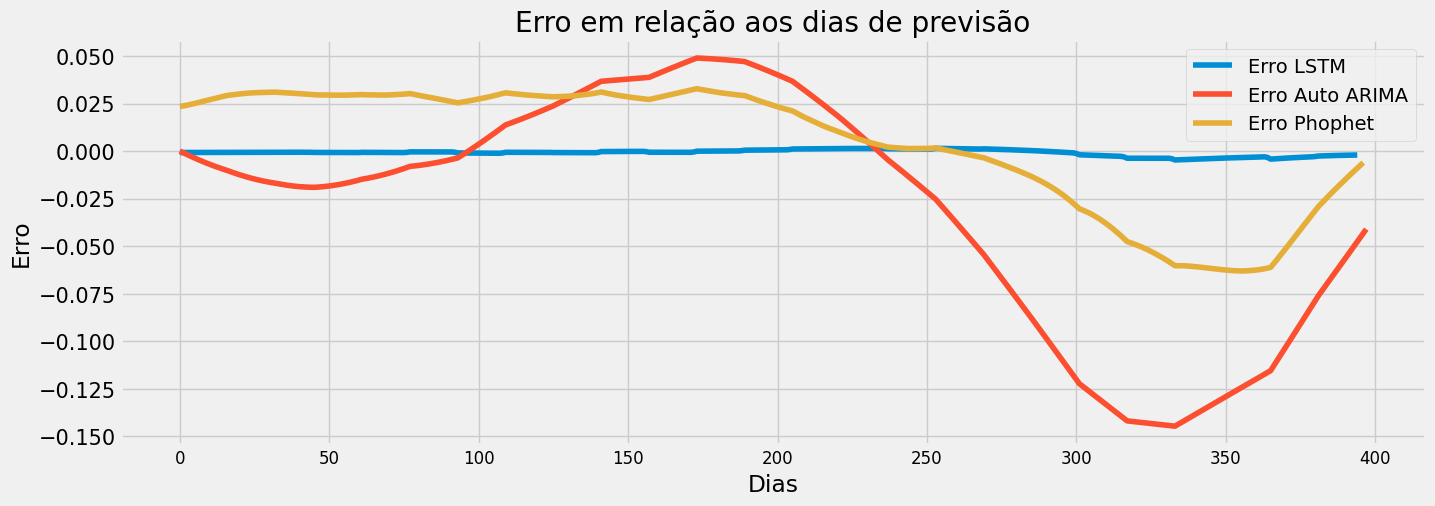

In [104]:
residualsLSTM.plot(ax=plt.gca())
residualsAA.plot(ax=plt.gca())
residualsPhophet.plot(ax=plt.gca())
plt.title('Erro em relação aos dias de previsão')
plt.ylabel("Erro")
plt.xlabel("Dias")

##Resumo de métricas

In [105]:
ResultsMetrics

,Model,R2_score,MAE,MSE,RMSE
0,Auto ARIMA,0.060252,0.050339,0.004566,0.067576
1,Prophet,0.785569,0.028172,0.001044,0.032318
2,LSTM,0.999353,0.001334,0.000003,0.001779
